In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import skew
import seaborn as sns
from xgboost import XGBRegressor
%matplotlib inline

df = pd.read_csv('./dataset/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


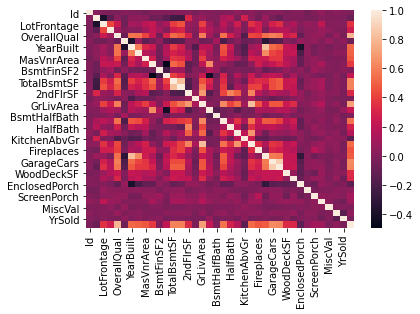

In [2]:
sns.heatmap(df.corr());

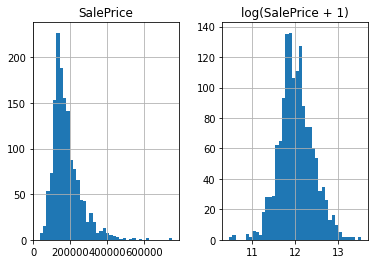

In [3]:
# comparing the price normalized vs non-normalized.
prices = pd.DataFrame({"SalePrice":df["SalePrice"], "log(SalePrice + 1)":np.log1p(df["SalePrice"])})
prices.hist(bins=40);

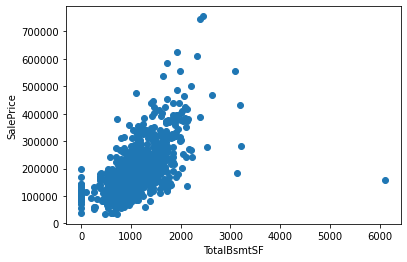

In [4]:
# Lookin at the relationship betwwen saleprice and TotalBsmtSF
plt.scatter(df['TotalBsmtSF'], df['SalePrice']);
plt.ylabel("SalePrice");
plt.xlabel("TotalBsmtSF");

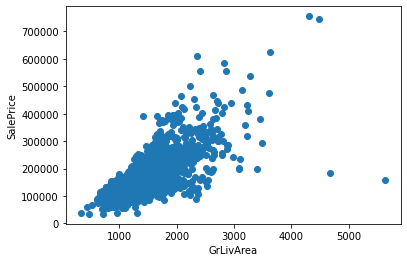

In [5]:
# Lookin at the relationship betwwen saleprice and GrLivArea
plt.scatter(df['GrLivArea'], df['SalePrice']);
plt.ylabel("SalePrice");
plt.xlabel("GrLivArea");

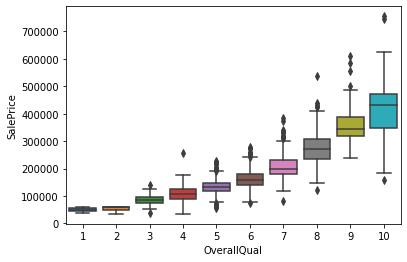

In [6]:
# Lookin at the relationship betwwen saleprice and overall quality
data = pd.DataFrame({"SalePrice":df["SalePrice"], "OverallQual": df["OverallQual"]})
sns.boxplot(x="OverallQual", y="SalePrice", data=data);

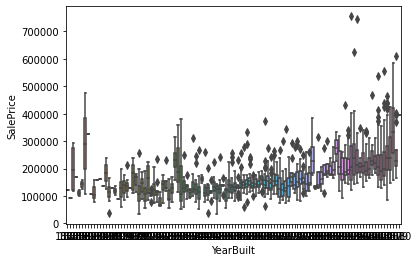

In [7]:
# Lookin at the relationship betwwen saleprice and built year
# plt.figure(figsize=(50,10))
data = pd.DataFrame({"SalePrice":df["SalePrice"], "YearBuilt": df["YearBuilt"]})
sns.boxplot(x="YearBuilt", y="SalePrice", data=data);

In [8]:
# computing the missing values.
sns.set_style("whitegrid")
missing = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, percent], axis=1, keys=['Total', 'Percent'])
missing_data[:10]

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [9]:
# dropping features whose entries are missing more than 80% of the time
df = df.drop((missing_data[missing_data['Percent'] > .8]).index, 1)

In [10]:
#log transform the target:
df["SalePrice"] = np.log1p(df["SalePrice"])

#log transform skewed numeric features:
numeric_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

df[skewed_feats] = np.log1p(df[skewed_feats])
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,4.110874,RL,4.189655,9.042040,Pave,Reg,Lvl,AllPub,Inside,...,0.000000,0.0,0.0,0.0,0.0,2,2008,WD,Normal,12.247699
1,2,3.044522,RL,4.394449,9.169623,Pave,Reg,Lvl,AllPub,FR2,...,0.000000,0.0,0.0,0.0,0.0,5,2007,WD,Normal,12.109016
2,3,4.110874,RL,4.234107,9.328212,Pave,IR1,Lvl,AllPub,Inside,...,0.000000,0.0,0.0,0.0,0.0,9,2008,WD,Normal,12.317171
3,4,4.262680,RL,4.110874,9.164401,Pave,IR1,Lvl,AllPub,Corner,...,5.609472,0.0,0.0,0.0,0.0,2,2006,WD,Abnorml,11.849405
4,5,4.110874,RL,4.442651,9.565284,Pave,IR1,Lvl,AllPub,FR2,...,0.000000,0.0,0.0,0.0,0.0,12,2008,WD,Normal,12.429220


In [11]:
df = pd.get_dummies(df)

In [12]:
# imputing data with the mean. This is a little bit dangerous and needs a thorough review/analysis of data.
df = df.fillna(df.mean())

In [13]:
X = df.drop(['SalePrice'], axis=1)
y = df.SalePrice

In [14]:
# defining our rmse funciton.
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    
    return(rmse)

In [15]:
# lets try fitting ridge model and compute the rmse. 
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
min(cv_ridge)

0.1265680515215692

In [16]:
# lets try fitting LassoCV model and compute the rmse. 
lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X, y)
rmse_cv(lasso).mean()

0.12206132199116373

In [ ]:
xgboost = XGBRegressor(learning_rate=0.05,n_estimators=2000, max_depth=3, min_child_weight=0, gamma=0, subsample=0.7,
                                     colsample_bytree=0.7, nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
rmse_cv(xgboost.fit(X, y)).mean()